# Jahresendauswertung

In [1]:
from lib import *
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, FuncFormatter
import numpy
from datetime import datetime, timedelta
from IPython.display import display, HTML
from scipy.ndimage import median_filter

In [2]:
#DB_PATH = r"N:\BC-Café\Cafe-CL\CL_Finanzer\Abrechnungssoftware2\Backend\data.db"
DB_PATH = r"D:\Felix\ILSC-Cloud\BC-Café\Cafe-CL\CL_Finanzer\Abrechnungssoftware2\Backend\data.db"
#DB_PATH = r"C:\ILSC-Cloud\BC-Café\Cafe-CL\CL_Finanzer\Abrechnungssoftware2\Backend\data.db"
db = sqlite3.connect(DB_PATH).cursor()

In [3]:
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

## Bilanz nach Bereichen

Kein Einkaufspreis zu Arikel Nr. 35.
Kein Einkaufspreis zu Arikel Nr. 39.
Kein Einkaufspreis zu Arikel Nr. 61.
Kein Einkaufspreis zu Arikel Nr. 66.
Kein Einkaufspreis zu Arikel Nr. 77.
Kein Einkaufspreis zu Arikel Nr. 82.
Kein Einkaufspreis zu Arikel Nr. 83.
Kein Einkaufspreis zu Arikel Nr. 84.


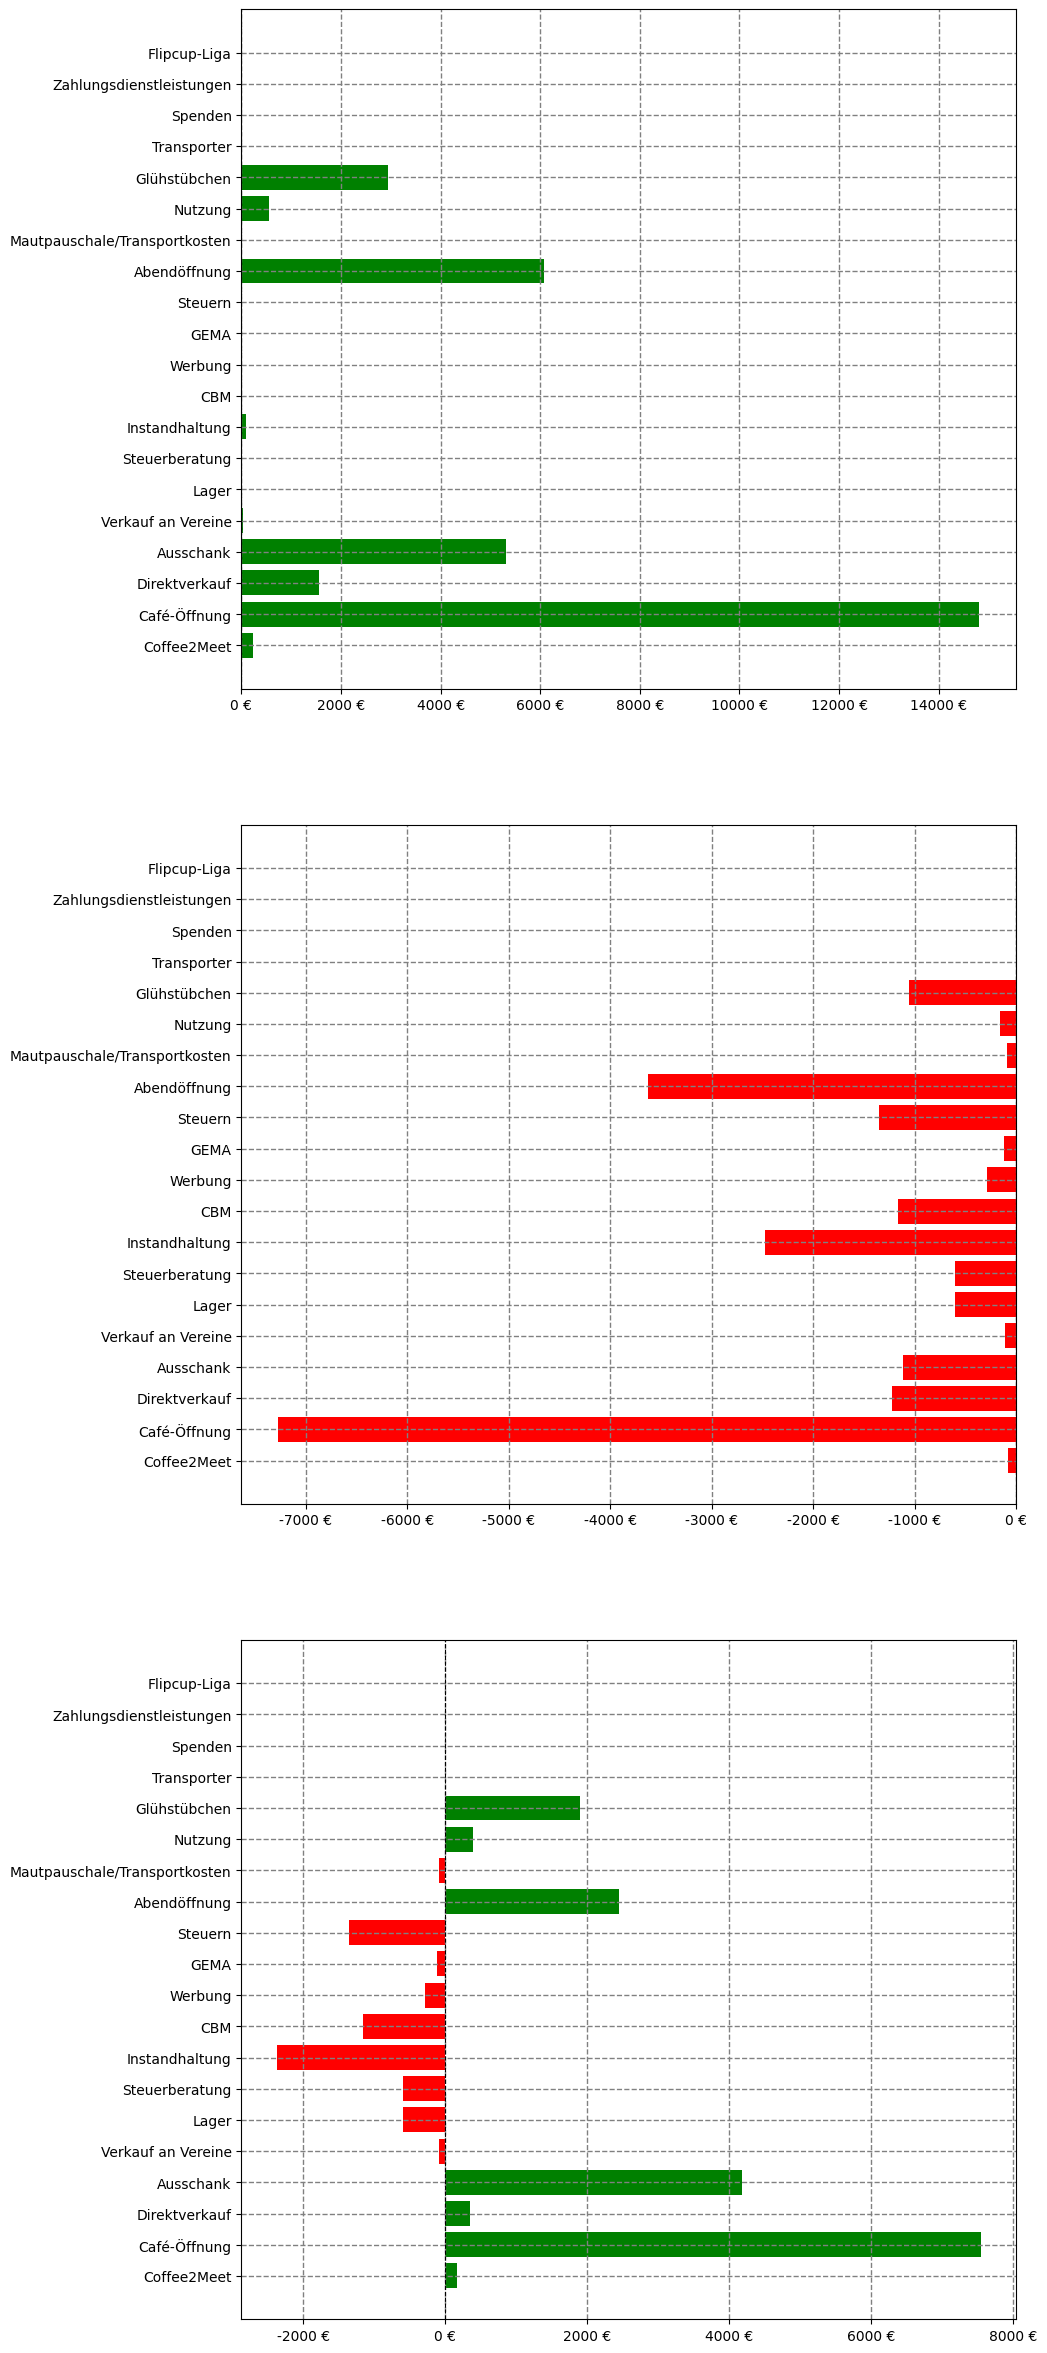

In [4]:
## alle Bereiche auflisten
bereiche = {}
for row in db.execute("SELECT id, name FROM Oeffnungsarten WHERE sichtbar AND id>0;"):
    bereiche[row[0]] = row[1]
# Einnahmen zu Bereichen sammeln
einnahmen = {bereich: 0 for bereich in bereiche}
for row in db.execute(f"""SELECT art, SUM(netto)
                        FROM Einnahmen
                        INNER JOIN Oeffnungen ON Oeffnungen.id=Einnahmen.oeffnung
                        WHERE STRFTIME('%s', datum) BETWEEN STRFTIME('%s', '{start_date}') AND STRFTIME('%s', '{end_date}')
                        GROUP BY art;"""):
    einnahmen[row[0]] = row[1]
# Einkaufsposten zu Bereichen sammeln
ausgaben = {bereich: 0 for bereich in bereiche}
einkauf_ausgaben = {bereich: 0 for bereich in bereiche}
for row in db.execute(f"""SELECT bereich, SUM(netto)
                        FROM EinkaufBereich
                        INNER JOIN Einkaeufe ON Einkaeufe.id=EinkaufBereich.einkauf
                        WHERE STRFTIME('%s', datum) BETWEEN STRFTIME('%s', '{start_date}') AND STRFTIME('%s', '{end_date}')
                        GROUP BY bereich;"""):
    ausgaben[row[0]] = row[1]
    einkauf_ausgaben[row[0]] = row[1]
# Einkaufsposten zu Öffnungen sammeln
for row in db.execute(f"""SELECT art, SUM(netto)
                        FROM EinkaufOeffnung
                        INNER JOIN Einkaeufe ON Einkaeufe.id=EinkaufOeffnung.einkauf
                        INNER JOIN Oeffnungen ON EinkaufOeffnung.oeffnung=Oeffnungen.id
                        WHERE STRFTIME('%s', Einkaeufe.datum) BETWEEN STRFTIME('%s', '{start_date}') AND STRFTIME('%s', '{end_date}')
                        GROUP BY art;"""):
    ausgaben[row[0]] += row[1]
    einkauf_ausgaben[row[0]] += row[1]
# Artikelverbrauche
verbrauche = []
verbrauche_sum = {}
artikel_kosten = {}
verbrauch_ausgaben = {bereich: 0 for bereich in bereiche}
for row in db.execute(f"""SELECT art, getraenk, SUM(differenz)
                        FROM OeffnungenVerbrauch
                        INNER JOIN Oeffnungen ON Oeffnungen.id=OeffnungenVerbrauch.oeffnung
                        WHERE STRFTIME('%s', datum) BETWEEN STRFTIME('%s', '{start_date}') AND STRFTIME('%s', '{end_date}')
                        GROUP BY getraenk, art;"""):
    verbrauche.append(row)
    if row[1] not in verbrauche_sum:
        verbrauche_sum[row[1]] = 0
    verbrauche_sum[row[1]] += row[2]
for bereich, artikel, menge in verbrauche:
    if artikel not in artikel_kosten:
        artikel_kosten[artikel] = get_kosten(db, artikel, end_date.year)
    kosten = artikel_kosten[artikel]
    if kosten < 1:
        print(f"Kein Einkaufspreis zu Arikel Nr. {artikel}.")
        continue
    ausgaben[bereich] += menge * kosten
    verbrauch_ausgaben[bereich] += menge * kosten
# eingekaufte Artikel ohne Verbrauchszuweisung
einkaufsmengen = []
for row in db.execute(f"""SELECT getraenk, SUM(menge), bereich
                        FROM Getraenke
                        INNER JOIN EinkaufArtikel ON Getraenke.id=EinkaufArtikel.getraenk
                        INNER JOIN Einkaeufe ON EinkaufArtikel.einkauf=Einkaeufe.id
                        WHERE STRFTIME('%s', datum) BETWEEN STRFTIME('%s', '{start_date}') AND STRFTIME('%s', '{end_date}')
                        AND bereich IS NOT NULL
                        GROUP BY getraenk;"""):
    einkaufsmengen.append(row)
for artikel, menge, bereich in einkaufsmengen:
    menge -= (verbrauche_sum[artikel] if artikel in verbrauche_sum else 0)
    if artikel not in artikel_kosten:
        artikel_kosten[artikel] = get_kosten(db, artikel, end_date.year)
    kosten = artikel_kosten[artikel]
    if kosten < 0:
        continue
    ausgaben[bereich] += menge * kosten
    verbrauch_ausgaben[bereich] += menge * kosten
# Visualisierung
fig = plt.figure(figsize=(10, 3*len(bereiche)//2))
format_xaxis = lambda z, _: f"{int(z/100)} €"
for i, (data, bezeichnung) in enumerate(zip([
    einnahmen,
    {bereich: -ausgaben[bereich] for bereich in bereiche},
    {bereich: einnahmen[bereich]-ausgaben[bereich] for bereich in bereiche}
], ["Einnahmen", "Ausgaben", "Saldo"])):
    plt.subplot(3, 1, i+1)
    plot_data = {bereiche[bereich]: data[bereich] for bereich in bereiche}.items()
    farben = ["red" if z < 0 else "green" for _, z in plot_data]
    plt.barh(*[[e[i] for e in plot_data] for i in range(2)], color=farben)
    plt.axvline(0, color="black", linewidth=0.8, linestyle="--")
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_xaxis))
    plt.grid(color="gray", linestyle="--", linewidth=1)

## Öffnungen/Verkäufe/Verbrauche
Hier wird alles aufgelistet, wo Geld eingenommen oder Waren herausgegeben wurden (meistens geht das ja miteinander einher und so).

In [5]:
DETAILLIERTE_AUFLISTUNG = False

html = '<div style="page-break-after: always;"></div>'
table_style = 'style="width:90%;border:1px solid black;"'
for bereich, bereich_name in bereiche.items():
    html += f'<h2>Bereich</h2><h1 style="font-size:60px;background-color:lime;width:100%;">{bereich_name}</h1>'
    if DETAILLIERTE_AUFLISTUNG:
        html += '<div style="page-break-after:always;">'
    # den Bereich betreffende Posten
    # Einkäufe
    einkaeufe = []
    for row in db.execute(f"""SELECT STRFTIME('%d.%m.%Y', datum), laden, SUM(netto)
                            FROM EinkaufBereich
                            INNER JOIN Einkaeufe ON Einkaeufe.id=EinkaufBereich.einkauf
                            WHERE STRFTIME('%s', datum) BETWEEN STRFTIME('%s', '{start_date}') AND STRFTIME('%s', '{end_date}')
                            AND bereich={bereich}
                            GROUP BY datum, laden
                            ORDER BY datum;"""):
        einkaeufe.append(row)
    if len(einkaeufe) > 0:
        einnahmensumme = 0
        if DETAILLIERTE_AUFLISTUNG:
            html += f'<table {table_style}><tr><td colspan="3" style="text-align:left;"><h4>Diesem Bereich zugeordnete Einkäufe</h4></td><tr><tr style="font-weight:bold;"><td>Datum</td><td>Verkäufer</td><td>Netto</td></tr>'
        for datum, laden, betrag in einkaeufe:
            einnahmensumme += betrag
            if DETAILLIERTE_AUFLISTUNG:
                html += f'<tr><td>{datum}</td><td>{laden}</td><td>{preis_string(betrag)}</td></tr>'
        if DETAILLIERTE_AUFLISTUNG:
            html += f'<tr><td colspan="2"><b>SUMME</b></td><td><b>{preis_string(einnahmensumme)}</b></td></tr></table>'
    # Verbrauche
    einkaufsmengen = []
    for row in db.execute(f"""SELECT getraenk, SUM(menge), einheit_kurz, name
                            FROM Getraenke
                            INNER JOIN EinkaufArtikel ON Getraenke.id=EinkaufArtikel.getraenk
                            INNER JOIN Einkaeufe ON EinkaufArtikel.einkauf=Einkaeufe.id
                            WHERE STRFTIME('%s', datum) BETWEEN STRFTIME('%s', '{start_date}') AND STRFTIME('%s', '{end_date}')
                            AND bereich={bereich}
                            GROUP BY getraenk;"""):
        einkaufsmengen.append(row)
    if len(einkaufsmengen) > 0:
        if DETAILLIERTE_AUFLISTUNG:
            html += f'<table {table_style}><tr><td colspan="4" style="text-align:left;"><h4>Diesem Bereich zugeordnete gekaufte Artikel</h4></td><tr><tr style="font-weight:bold;"><td>Artikel</td><td>Einzelpreis</td><td>Menge</td><td>Gesamtpreis</td></tr>'
        kostensumme = 0
        for artikel, menge, einheit, name in einkaufsmengen:
            menge -= (verbrauche_sum[artikel] if artikel in verbrauche_sum else 0)
            kosten = artikel_kosten[artikel]
            if kosten < 0:
                kosten = None
                gesamtkosten = None
            else:
                gesamtkosten = menge * kosten
                kostensumme += gesamtkosten
            if DETAILLIERTE_AUFLISTUNG:
                html += f'<tr><td>{name}</td><td>{preis_string(kosten)}</td><td>{menge:3.2f} {einheit}</td><td>{preis_string(gesamtkosten)}</td></tr>'
        if DETAILLIERTE_AUFLISTUNG:
            html += f'<tr><td colspan="3"><b>SUMME</b></td><td><b>{preis_string(kostensumme)}</b></td></tr></table>'
    # Bilanz
    if DETAILLIERTE_AUFLISTUNG:
        html += '<h2>Bilanz</h2>'
    einnahmen_ = einnahmen[bereich] if bereich in einnahmen else 0
    einkaeufe_ = -einkauf_ausgaben[bereich] if bereich in einkauf_ausgaben else 0
    verbrauche_ = -verbrauch_ausgaben[bereich] if bereich in verbrauch_ausgaben else 0
    html += f'<table><tr><td>Einnahmen</td><td>{preis_string(einnahmen_)}</td></tr>'
    html += f'<tr><td>Einkäufe</td><td>{preis_string(einkaeufe_)}</td></tr>'
    html += f'<tr><td>Verbrauche</td><td>{preis_string(verbrauche_)}</td></tr>'
    html += f'<tr><td><b>SUMME</b></td><td><b>{preis_string(einnahmen_+einkaeufe_+verbrauche_)}</b></td></tr></table>'
    html += '</div>'
    # Öffnungen auflisten
    oeffnungsliste = []
    for row in db.execute(f"""SELECT id, STRFTIME('%d.%m.%Y', datum), name 
                            FROM Oeffnungen 
                            WHERE art={bereich}
                            AND STRFTIME('%s', datum) BETWEEN STRFTIME('%s', '{start_date}') AND STRFTIME('%s', '{end_date}')
                            ORDER BY datum;"""):
        oeffnungsliste.append(row)
    for oeffnung, datum, oeffnung_name in oeffnungsliste:
        html += f'<h3>{oeffnung_name}, <small>{datum}</small></h3>'
        if DETAILLIERTE_AUFLISTUNG:
            html += f'<p><small>&#10165; zum Buchungsbereich {bereich_name}</small></p>'
        # Einnahmen
        oeff_einnahmen = []
        einnahmensumme = 0
        for row in db.execute(f"SELECT name, netto FROM Einnahmen WHERE oeffnung={oeffnung};"):
            oeff_einnahmen.append(row)
        if len(oeff_einnahmen) > 0:
            if DETAILLIERTE_AUFLISTUNG:
                html += f'<table {table_style}><tr><td colspan="2" style="text-align:left;"><h4>Einnahmen</h4></td><tr><tr style="font-weight:bold;"><td>Posten</td><td>Nettobetrag</td></tr>'
            for name, betrag in oeff_einnahmen:
                einnahmensumme += betrag
                if DETAILLIERTE_AUFLISTUNG:
                    html += f'<tr><td>{name}</td><td>{preis_string(betrag)}</td></tr>'
            if DETAILLIERTE_AUFLISTUNG:
                html += f'<tr><td><b>SUMME</b></td><td><b>{preis_string(einnahmensumme)}</b></td></tr></table>'
        # Artikelverbrauch
        artikelliste = []
        verbrauchkosten = 0
        for row in db.execute(f"""WITH T AS (
                                SELECT getraenk, differenz AS menge, Getraenke.name, einheit_kurz
                                FROM OeffnungenVerbrauch
                                INNER JOIN Oeffnungen ON Oeffnungen.id=OeffnungenVerbrauch.oeffnung
                                INNER JOIN Getraenke ON Getraenke.id=OeffnungenVerbrauch.getraenk
                                WHERE Oeffnungen.id={oeffnung}
                                UNION
                                SELECT getraenk, ende AS menge, Getraenke.name || ' (Schüttverlust)', einheit_kurz
                                FROM OeffnungenVerbrauch
                                INNER JOIN Oeffnungen ON Oeffnungen.id=OeffnungenVerbrauch.oeffnung
                                INNER JOIN Getraenke ON Getraenke.id=OeffnungenVerbrauch.getraenk
                                WHERE Oeffnungen.id={oeffnung}
                                AND reste=0)
                                SELECT * FROM T WHERE menge > 0 ORDER BY name;"""):
            artikelliste.append(row)
        if len(artikelliste) > 0:
            if DETAILLIERTE_AUFLISTUNG:
                html += f'<table {table_style}><tr><td colspan="3" style="text-align:left;"><h4>Verbrauch</h4></td><tr><tr style="font-weight:bold;"><td>Artikel</td><td>Verbrauch</td><td>Netto-Kosten</td></tr>'
            for artikel, menge, artikel_name, einheit in artikelliste:
                kosten = artikel_kosten[artikel] * menge
                if kosten < 0:
                    kosten = None
                else:
                    verbrauchkosten += kosten
                if DETAILLIERTE_AUFLISTUNG:
                    html += f'<tr><td>{artikel_name}</td><td>{menge:3.2f} {einheit}</td><td>{preis_string(kosten)}</td></tr>'
            if DETAILLIERTE_AUFLISTUNG:
                html += f'<tr><td colspan="2"><b>SUMME</b></td><td><b>{preis_string(verbrauchkosten)}</b></td></tr></table>'
        # Einkäufe
        einkaufliste = []
        einkaufkosten = 0
        for row in db.execute(f"""SELECT laden, netto
                                FROM Einkaeufe
                                INNER JOIN EinkaufOeffnung ON Einkaeufe.id=EinkaufOeffnung.einkauf
                                WHERE oeffnung={oeffnung};"""):
            einkaufliste.append(row)
        if len(einkaufliste) > 0:
            if DETAILLIERTE_AUFLISTUNG:
                html += f'<table {table_style}><tr><td colspan="2" style="text-align:left;"><h4>Einkäufe</h4></td><tr><tr style="font-weight:bold;"><td>Geschäft</td><td>Netto-Kosten</td></tr>'
            for laden, netto in einkaufliste:
                einkaufkosten += netto
                if DETAILLIERTE_AUFLISTUNG:
                    html += f'<tr><td>{laden}</td><td>{preis_string(netto)}</td></tr>'
            if DETAILLIERTE_AUFLISTUNG:
                html += f'<tr><td><b>SUMME</b></td><td><b>{preis_string(einkaufkosten)}</b></td></tr></table>'
        # Bilanz
        html += f'''<table style="width:90%;border:2px solid black;font-size:16px;"><tr><td colspan="2" style="text-align:left;"><h4>Bilanz</h4></td></tr>
            <tr><td>Einnahmen</td><td>{preis_string(einnahmensumme)}</td></tr>
            <tr><td>Verbrauchskosten</td><td>{preis_string(-verbrauchkosten)}</td></tr>
            <tr><td>Einkäufe</td><td>{preis_string(-einkaufkosten)}</td></tr>
            <tr><td><b>Summe</b></td><td><b>{preis_string(einnahmensumme-verbrauchkosten-einkaufkosten)}</b></td></tr>
            </table>'''
        if DETAILLIERTE_AUFLISTUNG:
            html += '<div style="page-break-after: always;"></div>'
display(HTML(html))
with open("bericht.html", "w") as f:
    f.write(f"<html><head></head><body>{html}</body></html>")

## Preisentwicklung von Produkten

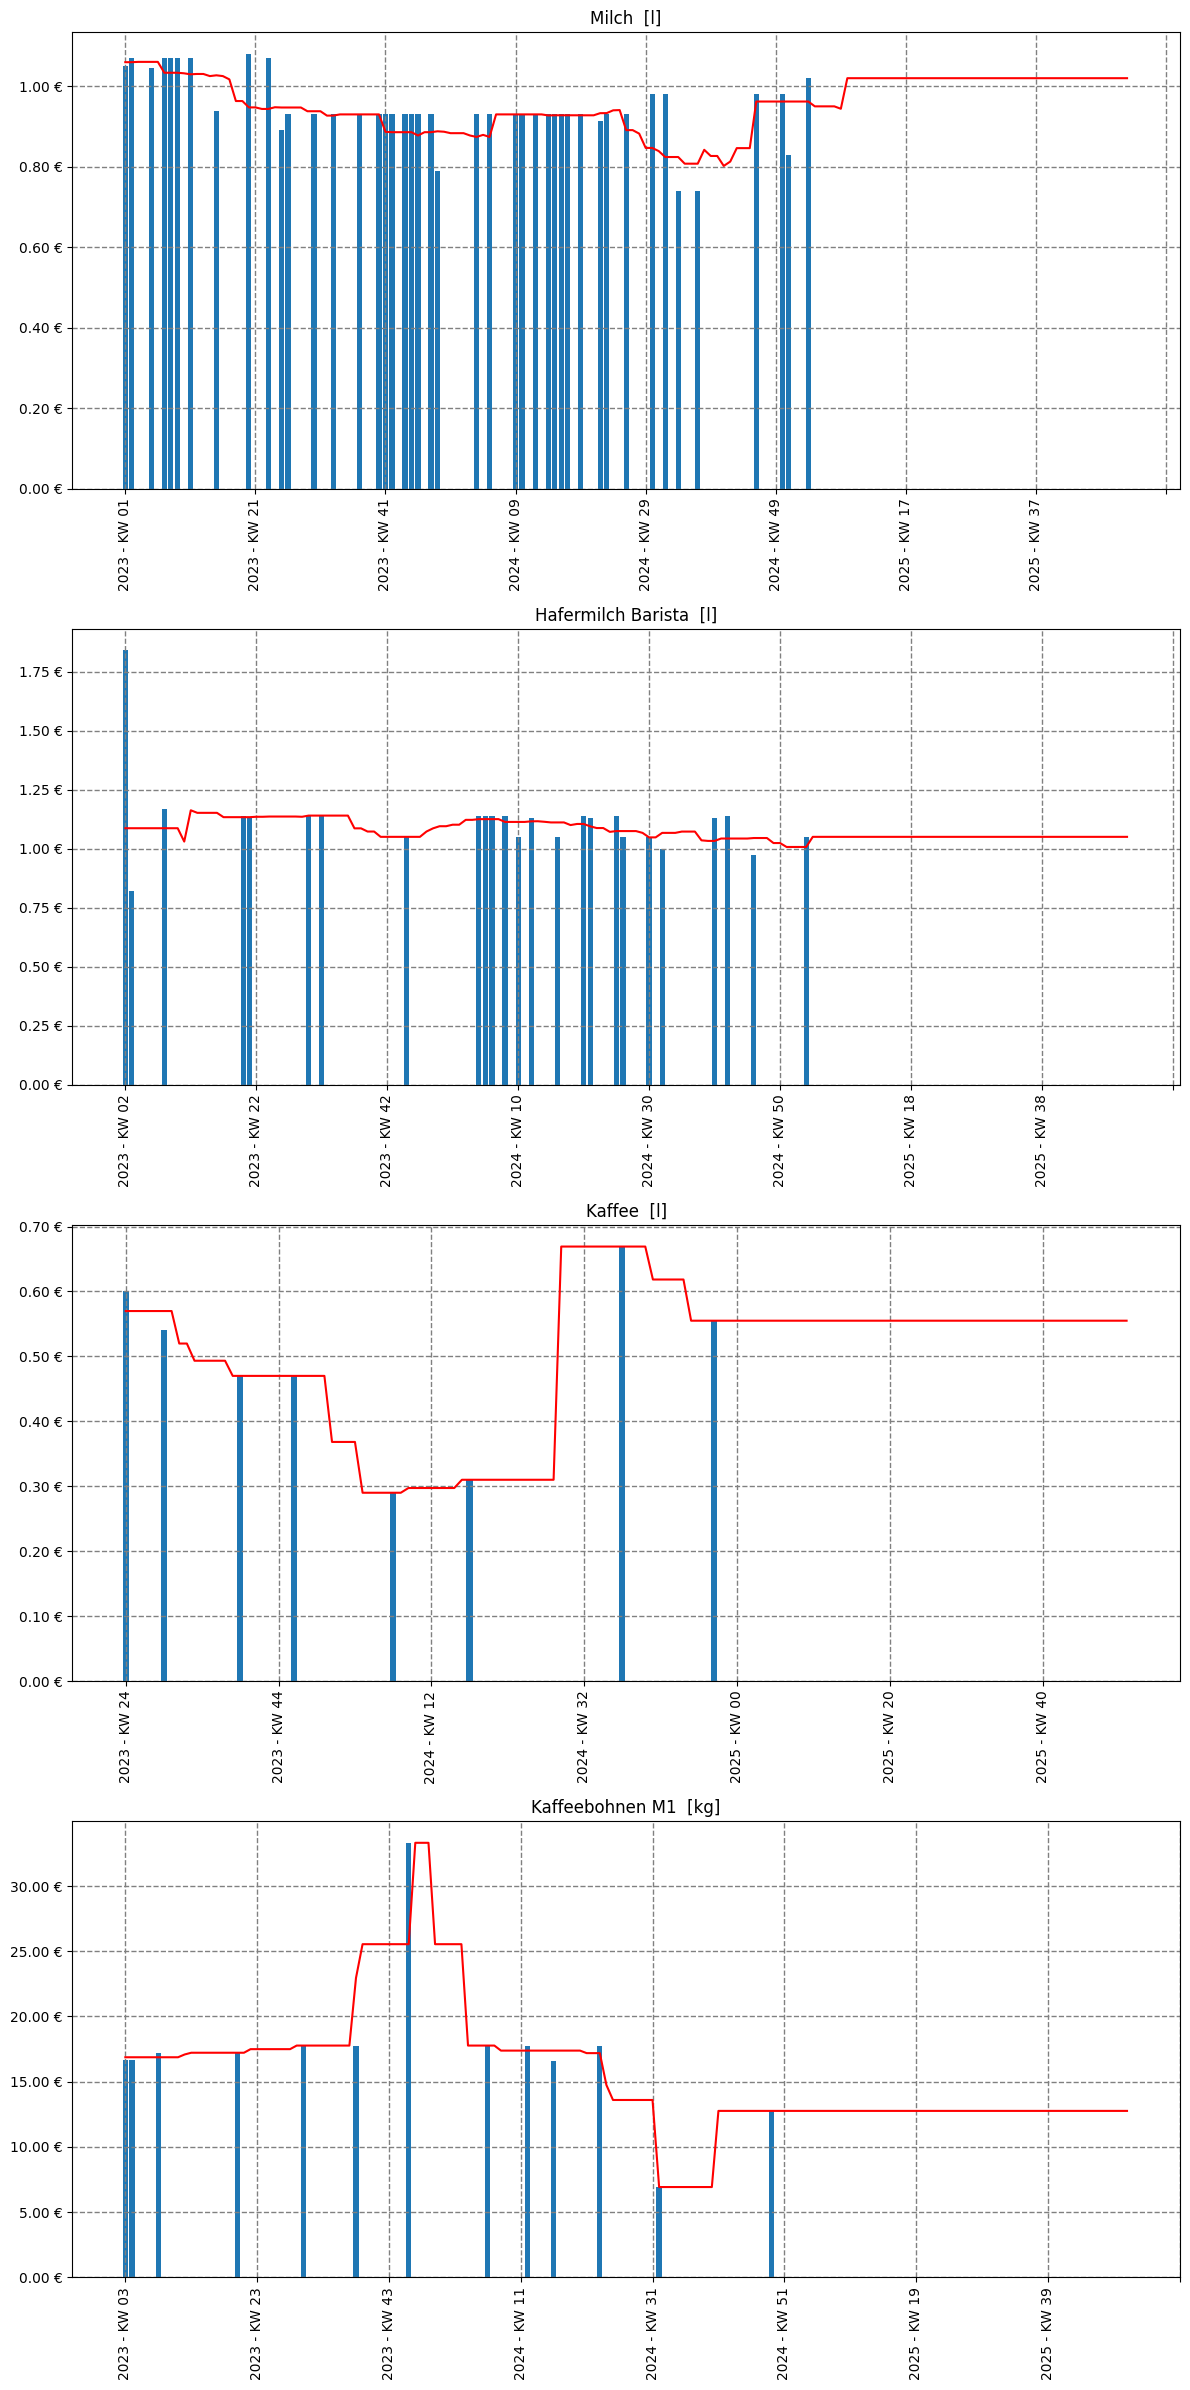

In [6]:
PRODUKTNAMEN = ["Milch", "Hafermilch Barista", "Kaffee", "Kaffeebohnen M1"]
RADIUS = 8
produkte = []
if len(PRODUKTNAMEN) > 0:
    for name in PRODUKTNAMEN:
        res = db.execute(f"SELECT id, einheit_kurz FROM Getraenke WHERE name='{name}';").fetchone()
        if res is None:
            print(f"Nicht gefunden: {name}")
        else:
            produkte.append((name, *res))
else:
    for row in db.execute(f"""SELECT DISTINCT name, Getraenke.id, einheit_kurz 
                              FROM Getraenke 
                              INNER JOIN 
                                  (SELECT * 
                                   FROM EinkaufArtikel 
                                   INNER JOIN Einkaeufe ON EinkaufArtikel.einkauf=Einkaeufe.id 
                                   WHERE STRFTIME('%s', datum) 
                                       BETWEEN STRFTIME('%s', '{start_date}') 
                                       AND STRFTIME('%s', '{end_date}')
                              ) EinkaeufeJahr ON Getraenke.id=EinkaeufeJahr.getraenk;"""):
        produkte.append(row)
fig = plt.figure(figsize=(12, 6*len(produkte)))
format_kw = lambda year, week: f"{year} - KW {str(week).zfill(2)}"
def trim(datum):
    global minimum_week
    datum = datetime.strptime(datum.split(" ")[0], "%Y-%m-%d").date()
    year = datum.year
    week = datum.isocalendar().week
    if year < minimum_week[0] or year == minimum_week[0] and week < minimum_week[1]:
        minimum_week = (year, week)
    return format_kw(year, week)
format_yaxis = lambda z, _: f"{z/100:.2f} €"
for i, (name, nr, einheit) in enumerate(produkte):
    minimum_week = (datetime.today().year, datetime.today().isocalendar().week)
    plt.subplot(len(produkte), 1, i+1)
    plt.title(f"{name}  [{einheit}]")
    einkaeufe = {}
    for row in db.execute(f"""SELECT datum, menge, einzel_netto 
                              FROM EinkaufArtikel 
                              INNER JOIN Einkaeufe ON Einkaeufe.id=EinkaufArtikel.einkauf 
                              WHERE getraenk={nr};"""):
        if trim(row[0]) not in einkaeufe:
            einkaeufe[trim(row[0])] = []
        einkaeufe[trim(row[0])].append((row[1], row[2]))
    einkaeufe = [(datum, numpy.average([e[1] for e in einkauf], weights=[e[0] for e in einkauf]), sum([e[0] for e in einkauf])) for datum, einkauf in einkaeufe.items()]
    for year in range(minimum_week[0], datetime.today().year+1):
        for week in range(datetime(year=year, month=12, day=28).isocalendar().week):
            week_str = format_kw(year, week)
            if not(year == minimum_week[0] and week < minimum_week[1]) and len(list(filter(lambda e: e[0] == week_str, einkaeufe))) == 0:
                einkaeufe.append((week_str, 0, 0))
    einkaeufe.sort(key=lambda e: e[0])
    plt.bar([e[0] for e in einkaeufe], [e[1] for e in einkaeufe])
    plt.xticks([e[0] for e in einkaeufe], rotation=90)
    preise = []
    for week_nr, _ in enumerate(einkaeufe):
        mengen_ = []
        preise_ = []
        for week in range(week_nr - RADIUS, week_nr + RADIUS + 1):
            if week < 0 or week >= len(einkaeufe):
                continue
            mengen_.append(einkaeufe[week][2])
            preise_.append(einkaeufe[week][1])
        if sum(mengen_) > 0:
            preise.append(numpy.average(preise_, weights=mengen_))
        else:
            preise.append(preise[-1] if len(preise) > 0 else 0)
    plt.plot([e[0] for e in einkaeufe], preise, color="red")
    plt.grid(color="gray", linestyle="--", linewidth=1)
    plt.gca().xaxis.set_major_locator(AutoLocator())
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
plt.tight_layout()
plt.show()

## Verlauf der Wocheneinnahmen

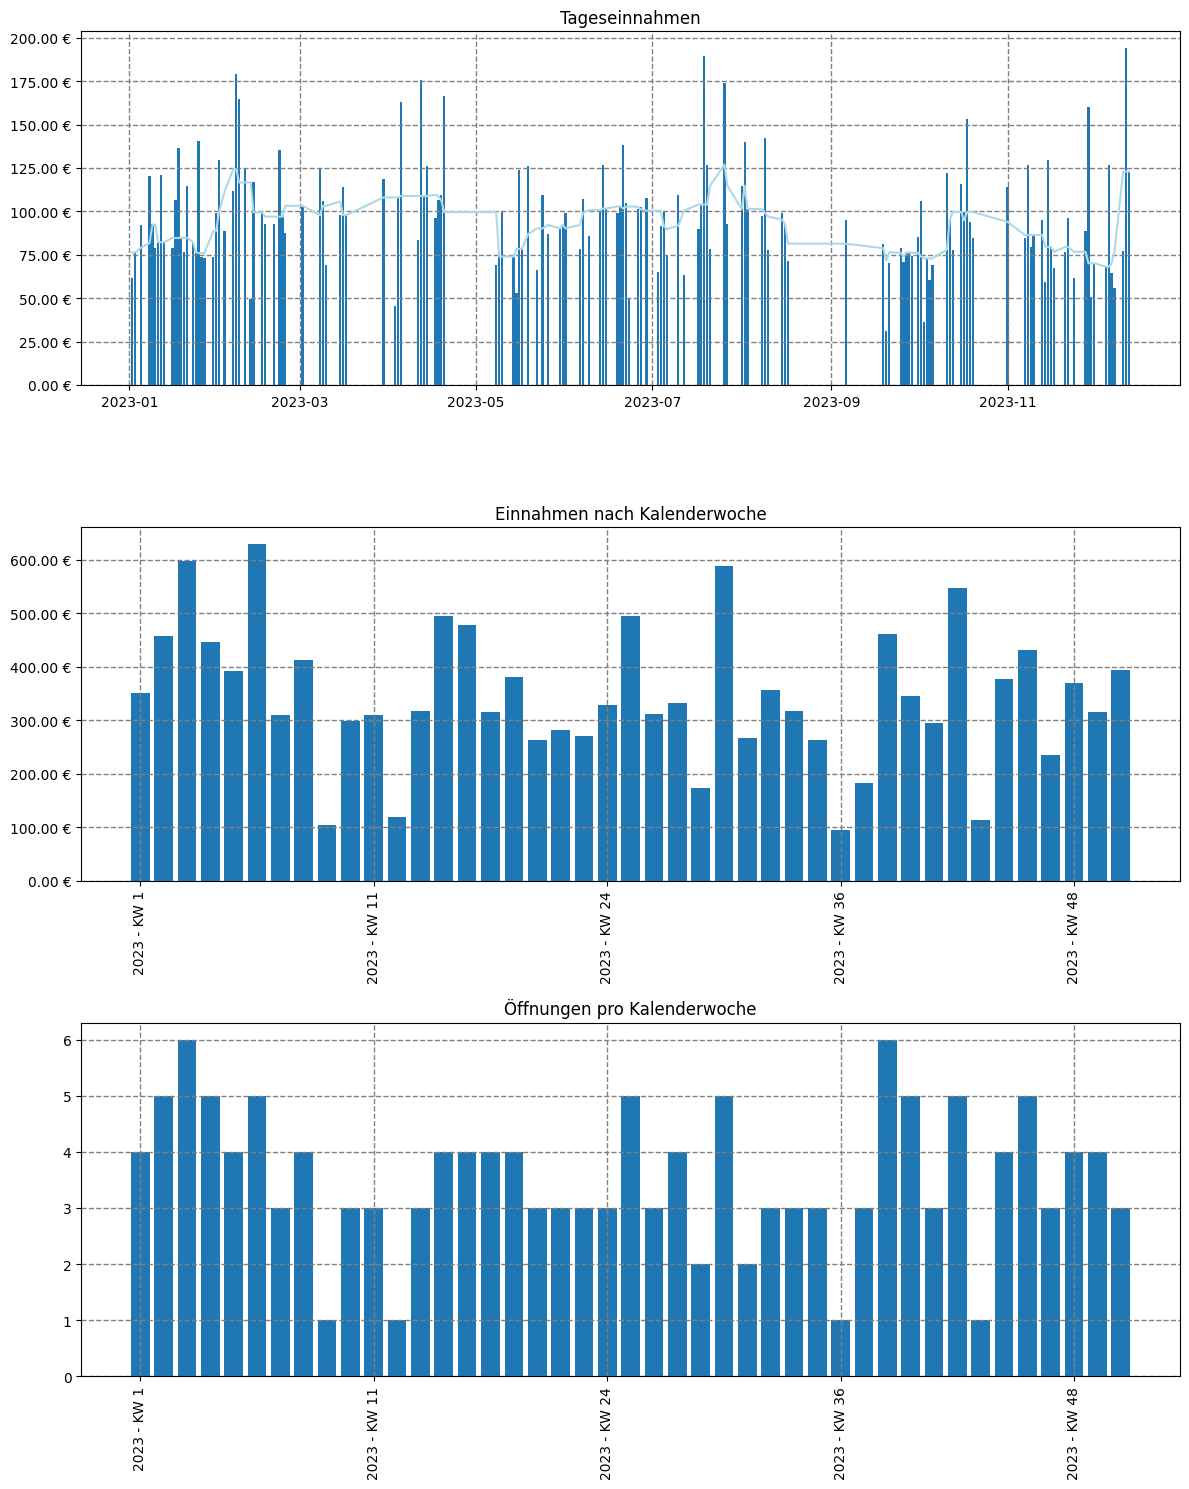

In [7]:
BEREICH_ID = 2
einnahmen = {}
einnahmen_kw = {}
zaehler_kw = {}
for datum, geld in db.execute(f'''SELECT datum, SUM(netto)
                        FROM Oeffnungen
                        INNER JOIN Einnahmen ON Oeffnungen.id=Einnahmen.oeffnung
                        WHERE STRFTIME('%s', datum) BETWEEN STRFTIME('%s', '{start_date}') AND STRFTIME('%s', '{end_date}')
                        AND art={BEREICH_ID}
                        GROUP BY datum;'''):
    datum = datetime.strptime(datum.split(" ")[0], "%Y-%m-%d")
    kw = datum.isocalendar().week
    jahr = datum.year
    einnahmen[datum] = geld
    if (jahr, kw) not in einnahmen_kw:
        einnahmen_kw[(jahr, kw)] = 0
        zaehler_kw[(jahr, kw)] = 0
    einnahmen_kw[(jahr, kw)] += geld
    zaehler_kw[(jahr, kw)] += 1
for jahr in range(start_date.year, end_date.year):
        for week in range(datetime(year=year, month=12, day=28).isocalendar().week):
            if not(year == start_date.year and week < start_date.isocalendar().week) and (jahr, week) not in zaehler_kw:
                zaehler_kw[(jahr, week)] = 0
                einnahmen_kw[(jahr, week)] = 0

plt.figure(figsize=(12, 15))
plt.subplot(3, 1, 1)
plt.title("Tageseinnahmen")
plt.bar(einnahmen.keys(), einnahmen.values())
plt.plot(einnahmen.keys(), median_filter(list(einnahmen.values()), size=7), color="lightblue")
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
plt.subplot(3, 1, 2)
plt.title("Einnahmen nach Kalenderwoche")
plt.bar([f"{j} - KW {w}" for j, w in einnahmen_kw.keys()], einnahmen_kw.values())
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.gca().xaxis.set_major_locator(AutoLocator())
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
plt.subplot(3, 1, 3)
plt.title("Öffnungen pro Kalenderwoche")
plt.bar([f"{j} - KW {w}" for j, w in einnahmen_kw.keys()], zaehler_kw.values())
plt.gca().xaxis.set_major_locator(AutoLocator())
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

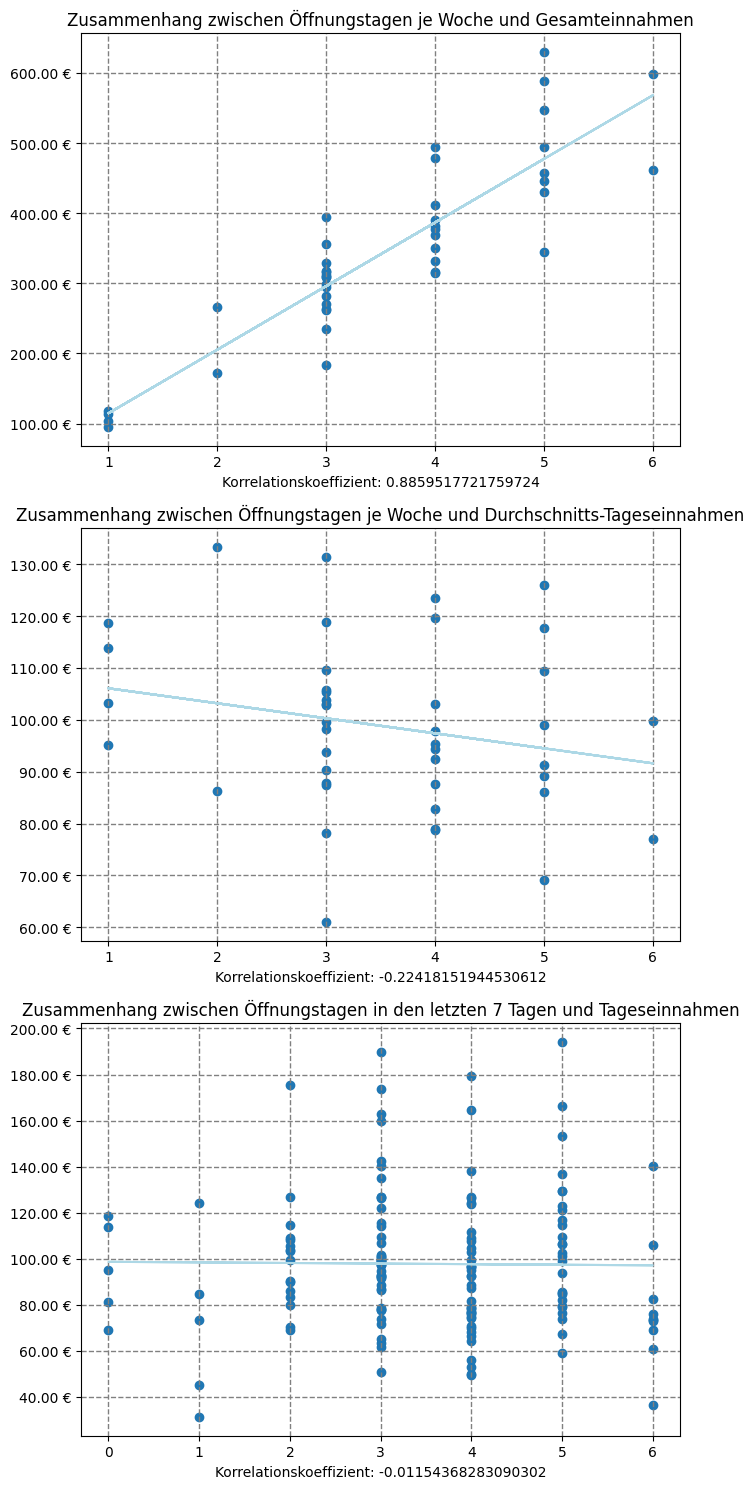

In [8]:
einnahmen_tage = numpy.array([(zaehler_kw[jahr, woche], einnahmen_kw[jahr, woche]) for jahr, woche in einnahmen_kw.keys()]).T
einnahmen_schnitt = numpy.vstack((einnahmen_tage[0], einnahmen_tage[1] / einnahmen_tage[0]))
plt.figure(figsize=(7,15))
plt.subplot(3, 1, 1)
plt.title("Zusammenhang zwischen Öffnungstagen je Woche und Gesamteinnahmen")
plt.scatter(*einnahmen_tage)
plt.plot(einnahmen_tage[0], numpy.poly1d(numpy.polyfit(*einnahmen_tage, 1))(einnahmen_tage[0]), color="lightblue")
plt.xlabel(f"Korrelationskoeffizient: {numpy.corrcoef(*einnahmen_tage)[0][1]}")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.subplot(3, 1, 2)
plt.title("Zusammenhang zwischen Öffnungstagen je Woche und Durchschnitts-Tageseinnahmen")
plt.scatter(*einnahmen_schnitt)
plt.plot(einnahmen_schnitt[0], numpy.poly1d(numpy.polyfit(*einnahmen_schnitt, 1))(einnahmen_schnitt[0]), color="lightblue")
plt.xlabel(f"Korrelationskoeffizient: {numpy.corrcoef(*einnahmen_schnitt)[0][1]}")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.subplot(3, 1, 3)
tage_zuvor = []
for datum in einnahmen.keys():
    if datum - timedelta(days=7) < min(einnahmen.keys()):
        continue
    valid = True
    tage_counter = 0
    for tage in range(1, 8):
        new_datum = datum - timedelta(days=tage)
        if new_datum in einnahmen:
            if einnahmen[new_datum] > 0:
                tage_counter += 1
    tage_zuvor.append([tage_counter, einnahmen[datum]])
tage_zuvor = numpy.array(tage_zuvor).T
plt.title("Zusammenhang zwischen Öffnungstagen in den letzten 7 Tagen und Tageseinnahmen")
plt.scatter(*tage_zuvor)
plt.plot(tage_zuvor[0], numpy.poly1d(numpy.polyfit(*tage_zuvor, 1))(tage_zuvor[0]), color="lightblue")
plt.xlabel(f"Korrelationskoeffizient: {numpy.corrcoef(*tage_zuvor)[0][1]}")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()